# Imports

In [57]:
import torch
import torch.nn as nn
import torchvision
import torchvision.transforms as transforms
import numpy as np
import matplotlib.pyplot as plt
import torch.utils.data as data_utils
from PIL import Image
import os
from datetime import datetime

# Data Loading
We want to upload our data in a format that a CNN can understand. In our case our images are 128 by 128 pixels with colors. The shape of each image is $(128, 128, 3)$.

```load_image``` transforms image to a ```numpy``` array of size $(128, 128, 3)$, while ```create_npy_from_image``` loops over images in a given directory and returns an array (```numpy```) of images.

In [26]:
def load_image(infilename):
    """This function loads an image into memory when you give it
       the path of the image
    """
    img = Image.open(infilename)
    img.load()
    data = np.asarray(img, dtype="float32")
    
    if data.shape[2] == 4:
        data = np.delete(data, 3, 2)
        
    return data, data.shape


def create_npy_from_image(images_class, st, en):
    """Loops through the images in a folder and saves all of them
       as a numpy array in output_name
    """

    data = []
    print("##############################################")
    print(f"class: {images_class}")
    for i in range(st, en+1):
        img, shape = load_image(f'./data/{images_class}/{images_class}{i}.png')
        data.append(img)
        if (i-1)%50 == 0:
            print(f"image number {i}: shape is {shape}")
    
    # filename.endswith(".jpg"):
    return np.array(data, dtype=np.object_)
    # return data

In [27]:
train_set, test_set = 250, 50
img_classes = ["cloth", "no_mask"]
train_data = []
test_data = []
for img_cl in img_classes:
    train_data.append(create_npy_from_image(img_cl, 1, train_set))
    test_data.append(create_npy_from_image(img_cl, train_set+1, train_set+test_set))

##############################################
class: cloth
image number 1: shape is (128, 128, 3)
image number 51: shape is (128, 128, 3)
image number 101: shape is (128, 128, 3)
image number 151: shape is (128, 128, 3)
image number 201: shape is (128, 128, 3)
##############################################
class: cloth
image number 251: shape is (128, 128, 3)
##############################################
class: no_mask
image number 1: shape is (128, 128, 3)
image number 51: shape is (128, 128, 3)
image number 101: shape is (128, 128, 3)
image number 151: shape is (128, 128, 3)
image number 201: shape is (128, 128, 3)
##############################################
class: no_mask
image number 251: shape is (128, 128, 3)


In [28]:
train_features = torch.Tensor(np.concatenate(train_data, axis=0).astype(np.int32))
train_targets = torch.Tensor(np.concatenate(([0 for i in range(train_set)], [1 for i in range(train_set)]), axis=0).astype(np.int32)).type(torch.IntTensor)

test_features = torch.Tensor(np.concatenate(test_data, axis=0).astype(np.int32))
test_targets = torch.Tensor(np.concatenate(([0 for i in range(test_set)], [1 for i in range(test_set)]), axis=0).astype(np.int32)).type(torch.IntTensor)

Last modification to our dataset is using ```data_utils.TensorDataset``` to transform our dataset to a [map-style datasets](https://pytorch.org/docs/stable/data.html#:~:text=of%20these%20options.-,Dataset%20Types,-The%20most%20important). This is useful because it automatically generates batches in the training loop and takes care of shuffling.

In [29]:
train_data = data_utils.TensorDataset(train_features, train_targets)
test_data = data_utils.TensorDataset(test_features, test_targets)

# Simple NN model

In [39]:
model = nn.Sequential(
    nn.Linear(49152, 128),
    nn.ReLU(),
    nn.Linear(128, 10)
)

In [40]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)
model.to(device)

cpu


Sequential(
  (0): Linear(in_features=49152, out_features=128, bias=True)
  (1): ReLU()
  (2): Linear(in_features=128, out_features=10, bias=True)
)

In [41]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters())

In [42]:
batch_size = 250
train_loader = torch.utils.data.DataLoader(dataset=train_data, 
                                           batch_size=batch_size, 
                                           shuffle=True)

test_loader = torch.utils.data.DataLoader(dataset=test_data, 
                                          batch_size=batch_size, 
                                          shuffle=False)

In [43]:
tmp_loader = torch.utils.data.DataLoader(dataset=train_data, 
                                           batch_size=1, 
                                           shuffle=True)

### Training

In [44]:
# Train the model
n_epochs = 100

# Stuff to store
train_losses = np.zeros(n_epochs)
test_losses = np.zeros(n_epochs)

for it in range(n_epochs):
    train_loss = []
    for inputs, targets in train_loader:
        # move data to GPU
        inputs, targets = inputs.to(device), targets.to(device).type(torch.LongTensor)

        # reshape the input
        inputs = inputs.view(-1, 49152)

        # zero the parameter gradients
        optimizer.zero_grad()

        # Forward pass
        outputs = model(inputs)
        loss = criterion(outputs, targets)

        # Backward and optimize
        loss.backward()
        optimizer.step()

        train_loss.append(loss.item())

    # Get train loss and test loss
    train_loss = np.mean(train_loss) # a little misleading
  
    test_loss = []
    for inputs, targets in test_loader:
        inputs, targets = inputs.to(device), targets.to(device).type(torch.LongTensor)
        inputs = inputs.view(-1, 49152)
        outputs = model(inputs)
        loss = criterion(outputs, targets)
        test_loss.append(loss.item())
    test_loss = np.mean(test_loss)

    # Save losses
    train_losses[it] = train_loss
    test_losses[it] = test_loss
    
    if (it+1)%10 == 0:
        print(f'Epoch {it+1}/{n_epochs}, Train Loss: {train_loss:.4f}, Test Loss: {test_loss:.4f}')

Epoch 10/100, Train Loss: 5.6762, Test Loss: 2.0194
Epoch 20/100, Train Loss: 2.2675, Test Loss: 2.2650
Epoch 30/100, Train Loss: 2.2335, Test Loss: 2.2310
Epoch 40/100, Train Loss: 2.2001, Test Loss: 2.1976
Epoch 50/100, Train Loss: 2.1677, Test Loss: 2.1654
Epoch 60/100, Train Loss: 2.1362, Test Loss: 2.1340
Epoch 70/100, Train Loss: 2.1055, Test Loss: 2.1033
Epoch 80/100, Train Loss: 2.0754, Test Loss: 2.0733
Epoch 90/100, Train Loss: 2.0458, Test Loss: 2.0438
Epoch 100/100, Train Loss: 2.0168, Test Loss: 2.0149


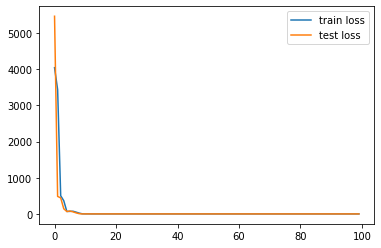

In [45]:
# Plot the train loss and test loss per iteration
plt.plot(train_losses, label='train loss')
plt.plot(test_losses, label='test loss')
plt.legend()
plt.show()

# CNN model

In [49]:
# number of classes
# K = len(set(train_data.targets.numpy()))
K = 2
print("number of classes:", K)

number of classes: 2


In [50]:
# Define the model
class CNN(nn.Module):
    def __init__(self, K):
        super(CNN, self).__init__()
        self.conv_layers = nn.Sequential(
          nn.Conv2d(in_channels=3, out_channels=32, kernel_size=3, stride=2),
          nn.ReLU(),
          nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, stride=2),
          nn.ReLU(),
          nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, stride=2),
          nn.ReLU()
        )
        # http://deeplearning.net/software/theano/tutorial/conv_arithmetic.html
        # "No zero padding, non-unit strides"
        # https://pytorch.org/docs/stable/nn.html
        self.dense_layers = nn.Sequential(
          nn.Dropout(0.2),
          nn.Linear(128 * 2 * 2, 512),
          nn.ReLU(),
          nn.Dropout(0.2),
          nn.Linear(512, K)
        )
  
    def forward(self, X):
        out = self.conv_layers(X)
        out = out.view(out.size(0), -1)
        out = self.dense_layers(out)
        return out


In [51]:
# Instantiate the model
model = CNN(K)

In [52]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)
model.to(device)

cpu


CNN(
  (conv_layers): Sequential(
    (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2))
    (1): ReLU()
    (2): Conv2d(32, 64, kernel_size=(3, 3), stride=(2, 2))
    (3): ReLU()
    (4): Conv2d(64, 128, kernel_size=(3, 3), stride=(2, 2))
    (5): ReLU()
  )
  (dense_layers): Sequential(
    (0): Dropout(p=0.2, inplace=False)
    (1): Linear(in_features=512, out_features=512, bias=True)
    (2): ReLU()
    (3): Dropout(p=0.2, inplace=False)
    (4): Linear(in_features=512, out_features=2, bias=True)
  )
)

In [53]:
# Loss and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters())

In [54]:
# Data loader
# Useful because it automatically generates batches in the training loop
# and takes care of shuffling

batch_size = 250
train_loader = torch.utils.data.DataLoader(dataset=train_data, 
                                           batch_size=batch_size, 
                                           shuffle=True)

test_loader = torch.utils.data.DataLoader(dataset=test_data, 
                                          batch_size=batch_size, 
                                          shuffle=False)

In [58]:
# A function to encapsulate the training loop
def batch_gd(model, criterion, optimizer, train_loader, test_loader, epochs):
    train_losses = np.zeros(epochs)
    test_losses = np.zeros(epochs)

    for it in range(epochs):
        model.train()
        t0 = datetime.now()
        train_loss = []
        for inputs, targets in train_loader:
            # move data to GPU
            inputs, targets = inputs.to(device), targets.to(device)

            # zero the parameter gradients
            optimizer.zero_grad()

            # Forward pass
            outputs = model(inputs)
            loss = criterion(outputs, targets)

            # Backward and optimize
            loss.backward()
            optimizer.step()

            train_loss.append(loss.item())

        # Get train loss and test loss
        train_loss = np.mean(train_loss) # a little misleading

        model.eval()
        test_loss = []
        for inputs, targets in test_loader:
            inputs, targets = inputs.to(device), targets.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, targets)
            test_loss.append(loss.item())
        test_loss = np.mean(test_loss)

        # Save losses
        train_losses[it] = train_loss
        test_losses[it] = test_loss

        dt = datetime.now() - t0
        print(f'Epoch {it+1}/{epochs}, Train Loss: {train_loss:.4f}, \
          Test Loss: {test_loss:.4f}, Duration: {dt}')
  
    return train_losses, test_losses

In [59]:
train_losses, test_losses = batch_gd(
    model, criterion, optimizer, train_loader, test_loader, epochs=15)

RuntimeError: Given groups=1, weight of size [32, 3, 3, 3], expected input[128, 128, 128, 3] to have 3 channels, but got 128 channels instead